# **Imports**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from sklearn.model_selection import GridSearchCV, KFold

from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.python.framework.random_seed import set_random_seed

import numpy as np
import cv2 as cv

from PIL import Image, ImageEnhance, ImageFilter
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Load Dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [ ]:
y_test_cat = to_categorical(y_test)
x_test_ready = normalize(flatten(x_test))

In [ ]:
def show_img(pos, X=x_train, cmap='gray'):
  plt.imshow(X[pos], cmap=cmap)
  plt.show()

**Convert array to images**

In [ ]:
def ndarray_to_PILIM(X):
  images = []
  for i in range(len(X)):
    images.append(Image.fromarray(X[i]))
  return images

def PILIM_to_ndarray(X):
  arrays = []
  for i in range(len(X)):
    arrays.append(np.asarray(X[i]))
  return np.array(arrays)

# **Preprocessing and Data Augmentation**

**Preprocessing and Data Augmentation**


1.   flattening
2.   contrast
3.   rotation
4.   normalization



images transformations

In [ ]:
def flatten(X):
  x_flat = np.zeros((X.shape[0],X[0].flatten().shape[0]))
  for i in range(X.shape[0]):
    x_flat[i] = X[i].flatten()
  return x_flat

def contrast(X, factor=1.5):
  out = []
  for im in X:
    enhancer = ImageEnhance.Contrast(im)
    res = enhancer.enhance(factor)
    out.append(res)
  return out

def rotate_img(image, angle=90):
  return image.rotate(angle)

def rotate(X, angle=90):
  x_rotated = list(map(rotate_img, X))
  return x_rotated

numerical transformations

In [ ]:
def normalize(X):
  x_norm = X/255
  return x_norm

In [ ]:
im_fun = ['contrast']
num_fun = ['normalize']

def preprocessing(X, y, im_fun=im_fun, num_fun=num_fun):
  out = ndarray_to_PILIM(X)
  x_images = ndarray_to_PILIM(X)
  if im_fun:
    for f in im_fun:
      out = out + globals()[f](x_images)
      y = np.concatenate((y, y))
  out = PILIM_to_ndarray(out)
  if num_fun:
    for f in num_fun:
      out = globals()[f](out)
  return flatten(out),y
  


In [ ]:

x_train_ready = normalize(flatten(x_train))
y_train_cat = to_categorical(y_train)


In [ ]:
x_train_ready, x_val, y_train_cat, y_val = train_test_split(
    x_train_ready, y_train_cat, test_size=0.2, shuffle=True,
    random_state=50
)

In [ ]:
x_val.shape

(12000, 784)

# **Models**

In [ ]:
"""
Returns a compiled model
- n_units: [list] number of neurons for each hidden layer
- activation_fs: [list] activation function for each hidden layer
- opt: the optimizer
- loss_f: the loss function. use "categorical_crossentropy" with one-hot encoding, and tf.keras.losses.SparseCategoricalCrossentropy() with KFold

nb: the size of n_units, activation_fs must be the same
"""
def MLP_definer(n_units, activation_fs, opt, loss_f):

  np.random.seed(50)
  set_random_seed(50)
 
  model = Sequential()
  model.add(Dense
            (input_dim = n_features, 
              units = n_features, 
              activation="relu"))
   
  for i in range(len(n_units)):
    model.add(Dense(
        units = n_units[i],
        activation = activation_fs[i],
        kernel_initializer = "random_uniform"))

  model.add(Dense(units = num_classes, activation='softmax')) #output layer

  model.compile(loss = loss_f, #tf.keras.losses.SparseCategoricalCrossentropy()
      optimizer = opt,  #optimizer
      metrics = ['accuracy']) #displayed metric


  return model



'''
The same function as above but we add a Dropout layer after each Dense 
- drop_prob: probability for the dropout layer (es. 0.30)
'''

def MLP_definer_drop(n_units, activation_fs, opt, drop_prob, loss_f):

  np.random.seed(50)
  set_random_seed(50)

  model = Sequential()
  model.add(Dense
            (input_dim = n_features, 
              units = n_features, 
              activation="relu"))
   
  for i in range(len(n_units)):
    model.add(Dense(
        units = n_units[i],
        activation = activation_fs[i]))
    
    model.add(Dropout(drop_prob))
    model.add(BatchNormalization())

  model.add(Dense(units = num_classes, activation='softmax')) #output layer

  model.compile(loss = loss_f, #tf.keras.losses.SparseCategoricalCrossentropy()
      optimizer = opt,  #optimizer
      metrics = ['accuracy']) #displayed metric


  return model

In [ ]:
def layer_builder(units, activation_f='relu', drop=False, batch_n=False, initializer='random_normal'):
  layer = Dense(units, activation = activation_f, kernel_initializer = initializer)
  out=[layer]

  if drop:
    drop_l = Dropout(drop)
    out.append(drop_l)
  if batch_n:
    batch_l = BatchNormalization()
    out.append(batch_l)

  return out

In [ ]:
def MLP_definer(layers, opt='sgd', loss_f='categorical_crossentropy', metrics=['accuracy'], n_class=10, n_features=784):
  np.random.seed(50)
  set_random_seed(50)

  model = Sequential()
  model.add(Dense(input_dim=n_features, units=n_features, activation='relu'))
  
  for i in range(len(layers)-1):
    for l in layers[i]:
      model.add(l)
      
  model.add(layers[-1])
  
  model.compile(loss=loss_f, optimizer=opt, metrics=metrics)
  return model


In [ ]:
layer_dict = {'units':[512,256,10],
              'activation_f':'relu',
              'drop':0.5,
              'batch_n':False,
              'kernel_initializer':'glorot_uniform'}

model_dict = {'opt':SGD(),
              'loss_f':'categorical_crossentropy',
              'metrics':['accuracy'],
              'n_features':784}



def MLP_builder(l_dict, m_dict):
  layers=[]

  for i in range(len(l_dict['units'])-1):
    new_l = layer_builder(l_dict['units'][i],
                          activation_f=l_dict['activation_f'],
                          drop=l_dict['drop'],
                          batch_n=l_dict['batch_n'],
                          initializer=l_dict['kernel_initializer'])
    layers.append(new_l)

  layers.append(Dense(l_dict['units'][-1],
                      activation='softmax'))
  

  model = MLP_definer(layers,
                      opt=m_dict['opt'],
                      loss_f=m_dict['loss_f'],
                      metrics=m_dict['metrics'],
                      n_features=m_dict['n_features'])
  return model

In [ ]:
def MLPs_builder(l_dict, m_dict):
  models = []

  for e in range(len(l_dict['activation_f'])):
    for p in range(len(l_dict['batch_n'])):
      for d in range(len(l_dict['drop'])):
        for k in range(len(l_dict['kernel_initializer'])):
          for ls_units in l_dict['units']:
            layersa = []
            for i in range(len(ls_units)-1):
              new_l = layer_builder(units=ls_units[i],
                                    initializer = l_dict['kernel_initializer'][k],
                                    activation_f = l_dict['activation_f'][e],
                                    drop = l_dict['drop'][d],
                                    batch_n = l_dict['batch_n'][p])
              layersa.append(new_l)
            
            layersa.append(Dense(ls_units[-1],
                            activation='softmax'))

            for o in range(len(m_dict['opt'])):
              model = MLP_definer(layers = layersa,
                                  opt = m_dict['opt'][o],
                                  loss_f = m_dict['loss_f'],
                                  n_features = m_dict['n_features'])

              models.append(model)

  return models

# **Tests**

Test funzioni costruzione modello

In [ ]:
def train_models(model_list, x, y, x_val, y_val, min_acc=0.7, epochs=50):
  hst=[]
  for model in model_list:
    print('Training model {}/{}'.format(model_list.index(model)+1, len(model_list)))
    model_hist = model.fit(x, y,
                           epochs=epochs,
                           batch_size=256,
                           validation_data=(x_val, y_val),
                           verbose=1)
    best_epoch = get_best_epoch(model_hist.history)
    if best_epoch['val_accuracy'] > min_acc:
      hst.append(model_hist)

  return hst

In [ ]:
def get_best_epoch(diz, watch='val_accuracy'):

  if(watch == "val_accuracy" or watch == "accuracy"):

    if(watch == "val_accuracy"):
      ls = diz.get("val_accuracy")
      acc_val_max = max(ls)
      ind = ls.index(acc_val_max)

      ls2 = diz.get("accuracy")
      acc_max = ls2[ind]

    elif(watch == "accuracy"):
      ls = diz.get("accuracy")
      acc_max = max(ls)
      ind = ls.index(acc_max)

      ls2 = diz.get("val_accuracy")
      acc_val_max = ls2[ind]

    ls1 = diz.get("loss")
    loss_ = ls1[ind]

    ls3 = diz.get("val_loss")
    loss_val_ = ls3[ind]

    out = {
        "accuracy": acc_max,
        "loss": loss_,
        "val_accuracy": acc_val_max,
        "val_loss": loss_val_,
        "ind": ind
        }

    return out

  else:
    print("only val_accuracy or accuracy are suitable params")

In [ ]:
def print_hist(hist_list):

  optimizers = [SGD, Adam]
  opt_names = ['SGD', 'Adam']
  initilizers = [GlorotUniform, GlorotNormal, RandomUniform, RandomNormal]
  init_names = ['glorot_uniform', 'glorot_normal', 'random_uniform', 'random_normal']

  for hst in hist_list:
    best = get_best_epoch(hst.history)
    print("============================================================================")

    units=[]
    for l in hst.model.layers:
      try:
        units.append(l.units)
      except:
        pass
    print('UNITS: ',units)

    for k in range(len(initilizers)):
      if isinstance(hst.model.layers[1].kernel_initializer, initilizers[k]):
        print("INIT: ",init_names[k], end=" - ")
        
    for i in range(len(optimizers)):
      if isinstance(hst.model.optimizer, optimizers[i]):
        print("OPT: {0}(lr={1:.3f})".format(opt_names[i],float(hst.model.optimizer.learning_rate.value())), end=" - ")
    
    #il primo layer di drop (se esiste) ha indice 2. (input, primo dense, drop)
    if isinstance(hst.model.layers[2], Dropout):
      print("DROP: ",hst.model.layers[2].rate, end=" - ")
    else:
      print("DROP: False", end=" - ")
    
    #il primo layer di batch normalization sta in posizione 2 o 3
    #a seconda che venga usato il drop o meno
    if isinstance(hst.model.layers[2], BatchNormalization):
      print("BATCH_NORM: True")
    else:
      if len(hst.model.layers) > 3 and isinstance(hst.model.layers[3], BatchNormalization):
        print("BATCH_NORM: True")
      else:
        print("BATCH_NORM: False")
    
    print("LAST VAL_ACC: ", hst.history["val_accuracy"][-1])
    print("LAST VAL_LOSS: ", hst.history["val_loss"][-1])
    print("BEST: ", best)

    plot_history(hst)

    print("============================================================================")

In [ ]:
def plot_history(histo):

  plt.plot(histo.history['accuracy'])
  plt.plot(histo.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

  plt.plot(histo.history['loss'])
  plt.plot(histo.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()
 

In [ ]:
opt_list = [SGD()]
layer_dict = {'units':[[512,256,128,64,32,30,20,10]],
              'activation_f': ['relu'],
              'drop': [False], 
              'batch_n': [False],
              'kernel_initializer': ['random_normal'] }


model_dict = {'opt': opt_list,
              'loss_f':'categorical_crossentropy',
              'metrics': ['accuracy'],
              'n_features': 784}

In [ ]:
model_list = MLPs_builder(layer_dict, model_dict)
print(len(model_list))

1


In [ ]:
print(model_list[0].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 784)               615440    
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                5

In [ ]:
hst = train_models(model_list, x_train_ready, y_train_cat, x_val, y_val, epochs=200)

Training model 1/1
Epoch 1/200
188/188 [==============================] - 2s 10ms/step - loss: 2.3026 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.0973
Epoch 2/200
188/188 [==============================] - 2s 8ms/step - loss: 2.3025 - accuracy: 0.1036 - val_loss: 2.3026 - val_accuracy: 0.0991
Epoch 3/200
188/188 [==============================] - 2s 8ms/step - loss: 2.3025 - accuracy: 0.1020 - val_loss: 2.3025 - val_accuracy: 0.0959
Epoch 4/200
188/188 [==============================] - 2s 9ms/step - loss: 2.3025 - accuracy: 0.1010 - val_loss: 2.3025 - val_accuracy: 0.1187
Epoch 5/200
188/188 [==============================] - 2s 8ms/step - loss: 2.3024 - accuracy: 0.1048 - val_loss: 2.3025 - val_accuracy: 0.1199
Epoch 6/200
188/188 [==============================] - 2s 9ms/step - loss: 2.3024 - accuracy: 0.1090 - val_loss: 2.3025 - val_accuracy: 0.0993
Epoch 7/200
188/188 [==============================] - 2s 8ms/step - loss: 2.3024 - accuracy: 0.1123 - val_loss: 2.3025 - 

In [ ]:
filtered_hst = []
for h in hst:
  best = get_best_epoch(h.history)
  if best['val_accuracy'] > 0.88:
    filtered_hst.append(h)
print(len(filtered_hst))

26


In [ ]:
np.save('roba_strana.npy',hst)

INFO:tensorflow:Assets written to: ram://8c05f469-9078-4eac-9da9-4496aac4b857/assets


In [ ]:
history=np.load('.npy',allow_pickle='TRUE')
len(history)

39

UNITS:  [784, 512, 256, 128, 64, 32, 30, 20, 10]
INIT:  random_normal - OPT: SGD(lr=0.010) - DROP: False - BATCH_NORM: False
LAST VAL_ACC:  0.8687499761581421
LAST VAL_LOSS:  0.41879019141197205
BEST:  {'accuracy': 0.9013749957084656, 'loss': 0.28580376505851746, 'val_accuracy': 0.8687499761581421, 'val_loss': 0.41879019141197205, 'ind': 99}


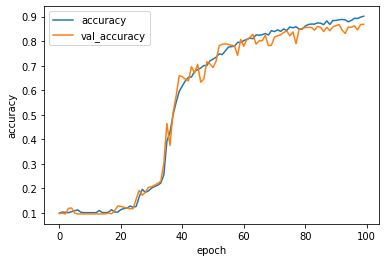

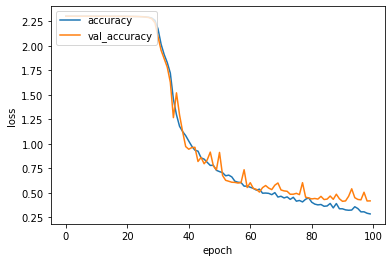

In [ ]:
print_hist(hst)

In [ ]:
def preprocessing(x):
    x = x.flatten()
    return x

In [ ]:
(x_train_fold, y_train_fold), (x_test_fold, y_test_fold) = tf.keras.datasets.fashion_mnist.load_data()

x_train_fold_ready = [preprocessing(x) for x in x_train_fold]
x_test_fold_ready = [preprocessing(x) for x in x_test_fold]

x_train_fold_ready = [x/255 for x in x_train_fold_ready]
x_test_fold_ready = [x/255 for x in x_test_fold_ready]

x_train_fold_ready = np.asarray(x_train_fold_ready)
x_test_fold_ready = np.asarray(x_test_fold_ready)

n_features = len(x_train_fold_ready[0])
print(n_features)
num_classes = 10

784


In [ ]:
set_train_full = ndarray_to_PILIM(x_train)

set_test_full = ndarray_to_PILIM(x_test)

factor = 1.5
resize = 64

set_train_contr = []
set_val_contr = []
set_test_contr = []

for im in set_train_full:
  #im = im.resize((resize, resize), resample=Image.LANCZOS)
  enhancer = ImageEnhance.Contrast(im)
  im = enhancer.enhance(factor)
  set_train_contr.append(im) 

for im in set_test_full:
  #im = im.resize((resize, resize), resample=Image.LANCZOS)
  enhancer = ImageEnhance.Contrast(im)
  im = enhancer.enhance(factor)
  set_test_contr.append(im) 

x_train_ready = PILIM_to_ndarray(set_train_contr)

x_test_ready = PILIM_to_ndarray(set_test_contr)

x_train_ready = [preprocessing(x) for x in x_train_ready]

x_test_ready = [preprocessing(x) for x in x_test_ready]

x_train_ready = [x/255 for x in x_train_ready]

x_test_ready = [x/255 for x in x_test_ready]

x_train_ready = np.asarray(x_train_ready)

x_test_ready = np.asarray(x_test_ready)

n_features = len(x_train_ready[0])
print(n_features)
num_classes = 10

#y_train_cat = to_categorical(y_train, num_classes)
#y_val_cat = to_categorical(y_val, num_classes)
#y_test_cat = to_categorical(y_test, num_classes)



784


In [ ]:
'''inputs = np.concatenate((x_train_fold_ready, x_test_fold_ready), axis=0)
targets = np.concatenate((y_train_fold, y_test_fold), axis=0)'''

inputs = x_train_ready
targets = y_train

acc_per_fold = []
loss_per_fold = []

NUM_FOLD = 10
kfold = KFold(n_splits = NUM_FOLD, shuffle = True)

In [ ]:
# K-fold Cross Validation model evaluation

n_units = [30, 20]
activation_fs = ["relu", "relu"]
opt  = [Adam()]

hst = []

fold_no = 1
for i in opt:
  for train, test in kfold.split(inputs, targets):

    model = MLP_definer_drop(n_units, activation_fs, i, 0.2, tf.keras.losses.SparseCategoricalCrossentropy())

    history = model.fit(inputs[train], targets[train],
                        batch_size = 256,
                        epochs = 70, 
                        verbose = 0)


    hst.append(history)
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')

Score for fold 1: loss of 0.3923262655735016; accuracy of 89.85000252723694%
Score for fold 2: loss of 0.43553343415260315; accuracy of 89.30000066757202%
Score for fold 3: loss of 0.413545161485672; accuracy of 89.83333110809326%
Score for fold 4: loss of 0.4242866635322571; accuracy of 89.85000252723694%
Score for fold 5: loss of 0.44610628485679626; accuracy of 88.88333439826965%
Score for fold 6: loss of 0.4638098180294037; accuracy of 88.95000219345093%
Score for fold 7: loss of 0.4022645652294159; accuracy of 89.81666564941406%
Score for fold 8: loss of 0.4053109884262085; accuracy of 89.64999914169312%
Score for fold 9: loss of 0.41773855686187744; accuracy of 90.36666750907898%
Score for fold 10: loss of 0.4763689339160919; accuracy of 88.98333311080933%
> Accuracy: 89.54833388328552 (+- 0.46865332915462093)
> Loss: 0.42772906720638276


In [ ]:
print_hist(hst)

TypeError: ignored

In [ ]:
acc=0
loss=0

for hist in hst:
  result = hist.model.evaluate(x_test_fold_ready, y_test, batch_size=256)
  acc = acc + result[1]
  loss = loss + result[0]

print(acc/10)
print(loss/10)

40/40 [==============================] - 0s 4ms/step - loss: 0.4185 - accuracy: 0.8906
0.8903600037097931
0.41363205313682555


In [ ]:
x_test_ready = normalize(flatten(x_test))
y_test_cat = to_categorical(y_test)

In [ ]:
results = model_list[0].evaluate(x_test_ready, y_test_cat, batch_size=1)

10000/10000 [==============================] - 37s 4ms/step - loss: 0.4550 - accuracy: 0.8579


In [ ]:
results

[0.4329693913459778, 0.8952000141143799]